In [1]:
import sys
import os
from pathlib import Path

# 获取当前工作目录，然后向上导航到 src 目录
current_dir = Path(os.getcwd())
# 假设当前在 code/src/learn 目录下，需要回到 code/src
src_path = current_dir.parent if current_dir.name == "learn" else current_dir
sys.path.insert(0, str(src_path))

from pprint import pprint  # noqa: E402
from utils.model import base  # noqa: E402
import numpy as np  # noqa: E402
import time  # noqa: E402

import torch.nn as nn  # noqa: E402
import torch  # noqa: E402
import torchvision.datasets as datasets  # noqa: E402

pprint(torch.cuda.is_available())
pprint(torch.cuda.device_count())

True
1


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# --- 1. 定义具体的模型 ---
class LinearRegression(base.ModernModule):
    def __init__(self, config: base.ModelConfig):
        super().__init__(config)
        # 实际的网络
        self.net = nn.LazyLinear(1)
        # 初始化权重
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def loss(self, y_hat, y):
        # 均方误差损失
        return nn.functional.mse_loss(y_hat, y.reshape(y_hat.shape))

# --- 2. 准备数据 (示例) ---
true_w = torch.tensor([2, -3.4])
true_b = 4.2
X = torch.randn(1000, 2)
y = torch.mv(X, true_w) + true_b
y += torch.randn(y.shape)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset, batch_size=32)

# --- 3. 组装并开始训练 ---
# 创建配置
config = base.ModelConfig(lr=0.03)
# 创建模型
model = LinearRegression(config)
# 创建回调
plotting_callback =base.PlottingCallback()
# 创建训练器
trainer = base.Trainer(max_epochs=5, callbacks=[plotting_callback])

# 开始训练！
trainer.fit(model, train_loader, val_loader)

In [2]:
class SoftMaxRegression(base.ModernModule):
    def __init__(self, config: base.ModelConfig):
        super().__init__(config)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10),  # 假设有10个类别
        )

    def loss(self, y_hat, y):
        # 使用交叉熵损失
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, X):
        # 返回预测的类别
        return self.net(X).argmax(dim=1)

    def predict_class(self, X):
        # 返回预测的类别
        return self.predict(X).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


datapath = "../../data/"


In [3]:
class MLPSoftMax(base.ModernModule):
    def __init__(self, config: base.ModelConfig):
        super().__init__(config)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(config.num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(config.output_size), 
        )
        
    def loss(self, y_hat, y):
        # 使用交叉熵损失
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, X):
        # 返回预测的类别
        return self.net(X).argmax(dim=1)

    def predict_class(self, X):
        # 返回预测的类别
        return self.predict(X).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.model.base import ModelConfig
# Fashion MNIST 数据集的预处理
transformer = transforms.Compose(
    [
        transforms.ToTensor(),  # 将PIL图像转换为Tensor
        transforms.Normalize((0.2860,), (0.3530,)),  # 标准化处理
    ]
)

# 从torchvision加载fashion MNIST数据集
fashion_mnist_train = datasets.FashionMNIST(
    root=datapath,
    train=True,
    download=True,
    transform=transformer,  # 应用预处理
)
fashion_mnist_test = datasets.FashionMNIST(
    root=datapath,
    train=False,
    download=True,
    transform=transformer,  # 应用预处理
)

num_classes = len(fashion_mnist_train.classes)
pprint(ModelConfig.available_devices())

['cuda:0']


In [9]:
# 强制检测GPU
import torch
import os

print("🔧 GPU诊断:")

# 检查所有可能的GPU
for i in range(10):  # 检查前10个可能的设备
    try:
        device = torch.cuda.device(i)
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    except:
        break

# 检查NVIDIA-ML-PY (如果安装了)
try:
    import pynvml
    pynvml.nvmlInit()
    device_count = pynvml.nvmlDeviceGetCount()
    print(f"NVML检测到的GPU数量: {device_count}")
    
    for i in range(device_count):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        name = pynvml.nvmlDeviceGetName(handle)
        print(f"NVML GPU {i}: {name}")
except ImportError:
    print("pynvml未安装，无法进行NVML检测")
except Exception as e:
    print(f"NVML检测失败: {e}")

🔧 GPU诊断:
GPU 0: NVIDIA GeForce RTX 4060
NVML检测到的GPU数量: 1
NVML GPU 0: NVIDIA GeForce RTX 4060


In [11]:

config = base.ModelConfig(
    lr=0.03,
    num_hiddens=256,
    output_size=num_classes,  # 输出类别数
    self_device = "cuda:0"
)

# 创建数据加载器
train_loader = DataLoader(fashion_mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(fashion_mnist_test, batch_size=32, shuffle=False)
model_linear = SoftMaxRegression(config)
model_mlp = MLPSoftMax(config)

print("📊 数据加载器信息:")
print(f"   训练批次数: {len(train_loader)}")
print(f"   验证批次数: {len(val_loader)}")
print("   批次大小: 32")
print(f"   输出类别数: {num_classes}")

pprint("🛠️ 模型配置:")
pprint(model_linear.self_device)
pprint(model_mlp.self_device)

📊 数据加载器信息:
   训练批次数: 1875
   验证批次数: 313
   批次大小: 32
   输出类别数: 10
'🛠️ 模型配置:'
device(type='cuda', index=0)
device(type='cuda', index=0)


In [12]:
trainer = base.Trainer(max_epochs=5, callbacks=base.DefaultCallbacks.with_live_loss())

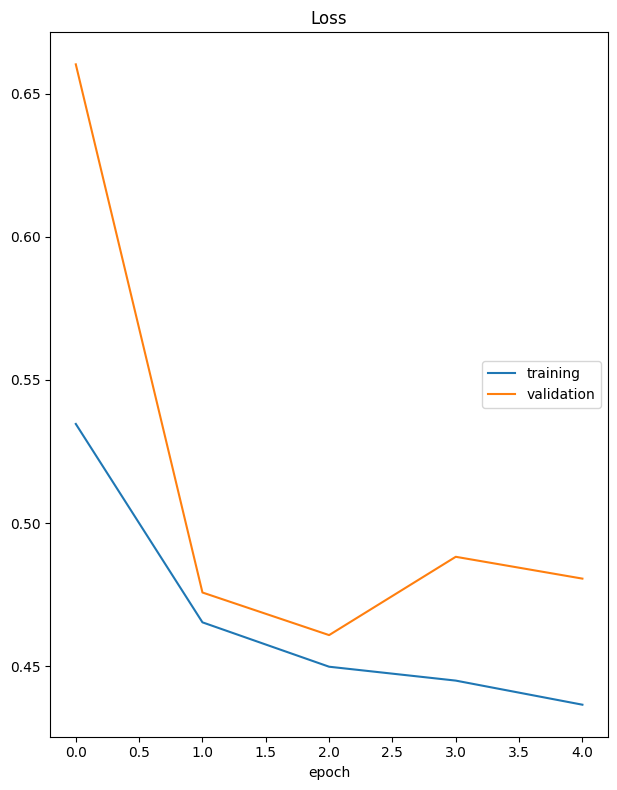

Loss
	training         	 (min:    0.436, max:    0.535, cur:    0.436)
	validation       	 (min:    0.461, max:    0.660, cur:    0.481)
✅ 训练完成！总用时: 1.8 分钟


In [13]:
trainer.fit(model_linear, train_loader, val_loader)

In [14]:
# 评估模型
print("📊 模型评估:"
      )
eval_results = model_linear.evaluate(
    torch.stack([x for x, _ in fashion_mnist_test]),
    torch.tensor([y for _, y in fashion_mnist_test])
)
print("   评估结果:", eval_results)

📊 模型评估:
   评估结果: {'loss': 0.4807618260383606, 'accuracy': 0.833299994468689, 'predicted_class': tensor([9, 2, 1,  ..., 8, 1, 5])}


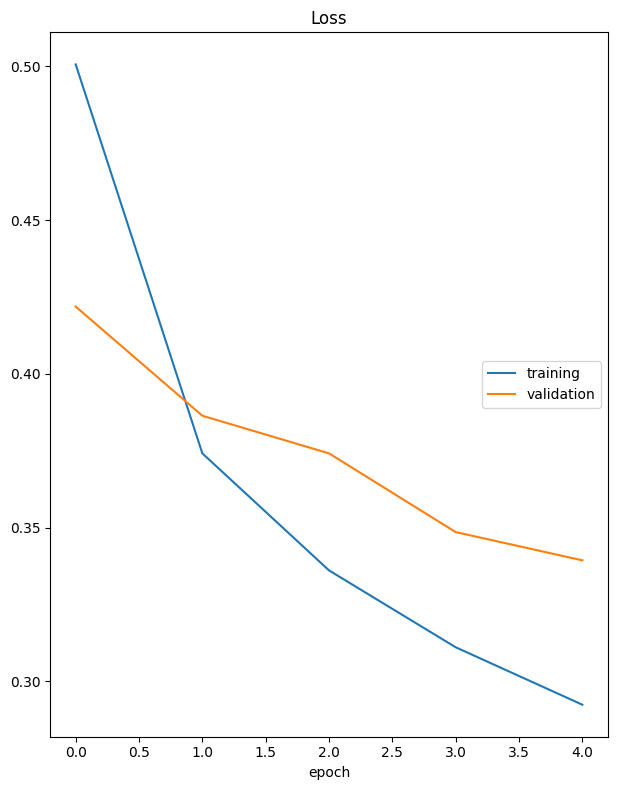

Loss
	training         	 (min:    0.292, max:    0.501, cur:    0.292)
	validation       	 (min:    0.339, max:    0.422, cur:    0.339)
✅ 训练完成！总用时: 1.4 分钟


In [20]:
mlp_trainer = base.Trainer(max_epochs=5, callbacks=base.DefaultCallbacks.with_live_loss())
model_mlp.to(model_mlp.self_device)  # 确保模型在正确的设备上
pprint(model_mlp.self_device)
pprint(model_linear.self_device)
# 创建一个辅助函数将DataLoader的数据转移到GPU
def create_gpu_dataloader(dataloader, device):
    """创建一个自动将数据移动到GPU的DataLoader包装器"""
    class GPUDataLoader:
        def __init__(self, dataloader, device):
            self.dataloader = dataloader
            self.device = device
        
        def __iter__(self):
            for batch in self.dataloader:
                # 将batch中的所有tensor移动到GPU
                yield tuple(item.to(self.device) if torch.is_tensor(item) else item for item in batch)
        
        def __len__(self):
            return len(self.dataloader)
    
    return GPUDataLoader(dataloader, device)

# 使用GPU DataLoader
gpu_train_loader = create_gpu_dataloader(train_loader, "cuda:0")
gpu_val_loader = create_gpu_dataloader(val_loader, "cuda:0")

mlp_trainer = base.Trainer(max_epochs=5, callbacks=base.DefaultCallbacks.with_live_loss())
model_mlp = model_mlp.to("cuda:0")
mlp_trainer.fit(model_mlp, gpu_train_loader, gpu_val_loader)

In [28]:
print("📊 模型评估:"
      )
# eval_results = model_mlp.evaluate(
#     torch.stack([x for x, _ in fashion_mnist_test]),
#     torch.tensor([y for _, y in fashion_mnist_test])
# )
# print("   评估结果:", eval_results)
print("模型在设备" + str(next(model_mlp.parameters()).device) + "上评估完成。")
print("数据集在设备" + str(torch.tensor([y for _, y in fashion_mnist_test]).device) + "上评估完成。")

📊 模型评估:
模型在设备cuda:0上评估完成。
数据集在设备cpu上评估完成。


In [22]:
if torch.cuda.is_available():
    print("GPU可用，正在释放GPU内存...")
    nums_gpus = torch.cuda.device_count()
    for i in range(nums_gpus):
        print(torch.cuda.get_device_name(i))
        
else:
    print("没有可用的GPU，使用CPU进行训练。")
    


GPU可用，正在释放GPU内存...
NVIDIA GeForce RTX 4060


In [24]:
gpu_id = 0
torch.cuda.set_device(gpu_id)
print(f"已设置当前GPU为: {torch.cuda.get_device_name(gpu_id)} (设备ID: {gpu_id})")

已设置当前GPU为: NVIDIA GeForce RTX 4060 (设备ID: 0)


In [25]:
tensor = torch.randn(100, 100).to(gpu_id)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.net = nn.Linear(100, 10)

    def forward(self, x):
        return self.net(x)

model = SimpleModel().cuda(gpu_id)

print("张量在设备上:", tensor.device)
print("模型在设备上:", next(model.parameters()).device)

张量在设备上: cuda:0
模型在设备上: cuda:0
